In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive


drive.mount('/content/drive')
root_path = 'drive/My Drive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


#when running from HDT: uncomment this
import sys, os
# when running from HDT: uncomment this
sys.path.append(root_path+"/Functions")

In [ ]:
from general_functions import *
from muscle_functions import *
#from integrator_functions import *
#from matrices_functions import * #can make specific later if bloated
from constants_functions import *
from plot_functions import *
from save_functions import *

In [ ]:


#must include 'longmuscle' for long muscle parameters, and 'shortmuscle' for short muscle parameters
experiment_name = 'newrepeated_smallstretch_longmuscle'#'zoomed'

#The stiffness region that the muscles start in must be in the specific_save_name. Names are:
#mostpos,verypos,newpos,newneg,mostneg for stiffness region 1-5. Region name must be preceded by stiff_start_
specific_save_name='stiff_start_newpos'#'stiff_start_neg','stiff_start_med','stiff_start_pos', depending on in which region it starts
saveornot=True      #If true, the experiment data will be saved to a dataset in /Results/data

#model type determines whether Huxley or Hill functions are used, v_type determines the used vce equation in the Huxley model (old is used) and FL_.. determines the used FL model (hill is used)
model_type,v_type,FL_type='huxley','v_old','FL_hill' #'huxley','hill'---'v_old','v_new'---'FL_0','FL_hill','FL_huxley'
FV_type='FV_hill'
hill_type = 'thijs'#thijs, stroeve #determines the hill model used. 'thijs' for hill_expanded, 'stroeve' for hill_simple
a_func=True #use an activation function


#some experiment parameters
fs=2500                     #steps/second
muscle_number = 1           #nr of muscles used
tot_bridge_nr = 25000       #number of cross-bridges in the Huxley Model
l_mtc0 = 0.32               #muscle length
Fmax_muscles = 1            #determines the fmax constant for the huxley model
Fmax_muscles_actual = 1     #determines the fmax constant for the hill model
mus_vals = muscle_vals_func()
h_step = 1/fs               #stepsize         (s)
t0 = 0.0                    #time start point (s)
tf = 2.3                    #time end point   (s)
step_nr = int(fs*(tf-t0))   #total steps











length_factor_array = [0,0.05]#[0,0.05,0,0.05,0.1,0.15,0.2,0.25,0.3]
velocity_scale_factor_array = [4.75,5.0,5.25,5.5]#[1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5] #1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5
for length_nr in range(len(length_factor_array)):
    if length_nr ==1:
        print('Done.')
    for veloc_nr in range(len(velocity_scale_factor_array)):


        length_factor = length_factor_array[length_nr]
        velocity_scale_factor = velocity_scale_factor_array[veloc_nr]


        v_mtc = np.zeros((step_nr+1))
        t1_start = 0.5#start velocity input
        t1_end = 0.9+ length_factor#end   velocity input
        velocity =0.8*mus_vals[0][8]#0.35*mus_vals[0][8]
        v_mtc[int(t1_start*fs+1):int(t1_end*fs)]=velocity#add negative stretch at low velocity
        t2_start = 2.01#2.01#start velocity input
        t2_end = 2.01 +0.5/velocity_scale_factor#2.15 #end   velocity input
        v_mtc[int(t2_start*fs+1):int(t2_end*fs)]=velocity*0.1*velocity_scale_factor

        time_vector=np.linspace(t0,tf,step_nr+1)
        l_mtc = l_mtc0*np.ones(step_nr+1)+h_step*np.cumsum(v_mtc)

        K_SE= np.zeros(step_nr+1)
        K_CE= np.zeros(step_nr+1)
        #plt.plot(time_vector,l_mtc)
        ##plt.ylabel('muscle length (m)')
        #plt.xlabel('time (s)')
        #plt.title('The forced muscle lengthenings & contraction')

        framemax_variable=-1#500
        for ii in range(3):
            model_type='huxley'
            if ii == 0:
                 save_name = '6hux_l'+str(length_factor)+'_v'+str(velocity_scale_factor)+'_'
            if ii == 1:
                model_type='hill'
                hill_type = 'thijs'
                save_name = '6thijs_l'+str(length_factor)+'_v'+str(velocity_scale_factor)+'_'
            if ii == 2:
                model_type='hill'
                hill_type = 'stroeve'
                save_name = '6stroeve_l'+str(length_factor)+'_v'+str(velocity_scale_factor)+'_'
            a=0

            if model_type=='huxley':
                states_hux = np.zeros((step_nr+1,tot_bridge_nr*2+2))
                #mus_vals_hux=mus_vals[0]
                mus_vals_hux = muscle_vals_func()
                mus_vals_changed,states_hux = constant_altering_function(mus_vals_hux[0],l_mtc0,states_hux,muscle_number,tot_bridge_nr,model_type,hill_type,Fmax_muscles_actual,experiment_name,specific_save_name)
                STIM = np.ones(len(time_vector))
                STIM[0:int(0.5*fs)]=0
                ti = t0
                calculated_muscle_forces = np.zeros((step_nr+1,3))
                while a < step_nr:
                        t_counter = ti
                        ti += h_step

                        states_previous_step = states_hux[a]
                        states_previous_step2 = states_hux[a-1]
                        calculated_muscle_forces_previous_step = calculated_muscle_forces[a]
                        F_per_step, state_current_step,K_SE_single,K_CE_single = huxley(l_mtc[a],v_mtc[a],states_previous_step,t_counter,h_step,mus_vals_changed,tot_bridge_nr,STIM[a],False,True,FL_type,v_type,states_previous_step2,calculated_muscle_forces_previous_step)#calculates the muscle force per muscle per cross-bridge for the current length and velocity values
                        a += 1
                        states_hux[a] = state_current_step
                        calculated_muscle_forces[a] = F_per_step
                        K_SE[a] = K_SE_single
                        K_CE[a] = K_CE_single
                lCE = states_hux[:,-2]
                lSE = l_mtc - lCE
                vCE = np.gradient(lCE,h_step)
                vSE = np.gradient(lSE,h_step)
                vCEhux = vCE
            if model_type=='hill':
                states2 = np.zeros((step_nr+1,2))
                mus_vals_hill = muscle_vals_func()
                mus_vals_changed2,states2 = constant_altering_function(mus_vals_hill[0],l_mtc0,states2,muscle_number,tot_bridge_nr,model_type,hill_type,Fmax_muscles,experiment_name,specific_save_name)
                #print(mus_vals_changed2)
                ti = t0
                STIM = np.ones(len(time_vector))
                STIM[0:int(0.1*fs)]=0
                force_vector = np.zeros((step_nr+1,9))
                force_vector[0][6],force_vector[0][4]=1,0.2#FLFV
                force_vector[0][2]=1/8*mus_vals_changed2[7]
                force_vector[0][1]=1/4*mus_vals_changed2[7]
                calculated_hill_forces = np.zeros((step_nr+1))
                while a < step_nr:
                        t_counter = ti
                        ti += h_step

                        force_vector_previous_step = force_vector[a]
                        states_previous_step = states2[a]
                        #force_vector_previous_stepl_mtc,v_mtc,states_previous_step,force_vector_previous_step,t_counter,h_step, mus_vals,STIM,FV_type='FV_hill',activation_function=True
                        F_hill, new_states = hill(l_mtc[a],v_mtc[a],states_previous_step,force_vector_previous_step,t_counter,h_step, mus_vals_changed2,STIM[a],hill_type,FV_type,a_func)#calculates the muscle force per muscle per cross-bridge for the current length and velocity values
                        a += 1
                        #F_hill[0],F_hill[1],F_hill[2],F_hill[3] = F_hill[0]*Fmax_muscles_actual,F_hill[1]*Fmax_muscles_actual,F_hill[2],F_hill[3]*Fmax_muscles_actual
                        states2[a] = new_states
                        calculated_hill_forces[a] = F_hill[0]
                        force_vector[a] = F_hill
                #lCE = l_mtc - 0.02
                lCE = states2[:,0]
                vCE = np.gradient(lCE,h_step)
                if ii == 1:
                    calculated_hill_forces_FVhill = calculated_hill_forces
                    force_vector_FVhill = force_vector
                    states_FVhill = states2
                if ii == 2:
                    calculated_hill_forces_FV0 = calculated_hill_forces
                    force_vector_FV0 = force_vector
                    states_FV0 = states2
            if model_type=='huxley':
                K_SE2 = np.zeros(len(lSE))
                K_PE2 = np.zeros(len(lSE))
                for i in range(len(lSE)):
                    K_SE2[i],K_PE2[i] = EE_Thelen(mus_vals_changed,lSE[i],0)
                #plot_huxley_full(time_vector, calculated_muscle_forces,states_hux,t0,tf,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals,lSE,lCE,vSE,vCE,l_mtc,v_mtc,K_SE2,False,K_CE)
            # if model_type=='huxley':
            #     plt.plot(l_mtc[1:],calculated_muscle_forces[:,2][1:])
            # if model_type=='hill':
            #     plt.plot(l_mtc[1:],calculated_hill_forces[1:])
            if model_type =='huxley':
                save_huxley(l_mtc,tot_bridge_nr,states_hux,STIM,calculated_muscle_forces,v_mtc,lCE,lSE,K_SE2,time_vector,save_name,specific_save_name,saveornot)
            if model_type =='hill':
                save_hill(l_mtc,calculated_hill_forces,force_vector,v_mtc,STIM,lCE,vCE,time_vector,save_name,specific_save_name,saveornot)
#         save_name = '_l'+str(length_factor)+'_v'+str(velocity_scale_factor)+'_'
#         framemax_variable1 = 1800
#         fig, axes = plt.subplots(1,1)
#         axes.plot(l_mtc[framemax_variable1:framemax_variable],calculated_muscle_forces[:,2][framemax_variable1:framemax_variable],label='huxley')
#         axes.plot(l_mtc[framemax_variable1:framemax_variable],calculated_hill_forces_FVhill[framemax_variable1:framemax_variable],label='hill1 (TU) simple FV')
#         axes.plot(l_mtc[framemax_variable1:framemax_variable],calculated_hill_forces[framemax_variable1:framemax_variable],label='hill2 (stroeve)')
#         axes.set_title('FL between the models')
#         axes.set_xlabel('muscle length (m)')
#         axes.set_ylabel('force (N)')
#         axes.legend()
#         fig.savefig('Results/'+save_name+'FL_all_EXP1c.png')

#         fig, axes = plt.subplots(1,1)
#         axes.plot(time_vector[1:framemax_variable],calculated_muscle_forces[:,2][1:framemax_variable],label='huxley')
#         axes.plot(time_vector[1:framemax_variable],calculated_hill_forces_FVhill[1:framemax_variable],label='hill1 (TU) simple FV')
#         axes.plot(time_vector[1:framemax_variable],calculated_hill_forces[1:framemax_variable],label='hill2 (stroeve)')
#         axes.set_title('Force-time of the models')
#         axes.set_xlabel('time (s)')
#         axes.set_ylabel('force (N)')
#         axes.legend()
#         fig.savefig('Results/'+save_name+'Ft_all_EXP1c.png')

#         framemin_variable=5000#14800
#         framemax_variable2=int(fs*(2.02 +0.5/velocity_scale_factor))#15800
#         fig, axes = plt.subplots(1,1)
#         axes.plot(time_vector[framemin_variable:framemax_variable2],calculated_muscle_forces[:,2][framemin_variable:framemax_variable2],label='huxley')
#         axes.plot(time_vector[framemin_variable:framemax_variable2],calculated_hill_forces_FVhill[framemin_variable:framemax_variable2],label='hill1 (TU) simple FV')
#         axes.plot(time_vector[framemin_variable:framemax_variable2],calculated_hill_forces[framemin_variable:framemax_variable2],label='hill2 (stroeve)')
#         axes.set_title('Zoomed force-time')
#         axes.set_xlabel('time (s)')
#         axes.set_ylabel('force (N)')
#         axes.legend()
#         fig.savefig('Results/'+save_name+'Ftzoomed_all_EXP1c.png')

0.05936000000000001
<xarray.Dataset>
Dimensions:  (time: 5751)
Coordinates:
  * time     (time) float64 0.0 0.0004 0.0008 0.0012 ... 2.299 2.299 2.3 2.3
Data variables:
    Fce_mtc  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9809 0.9809 0.9809 0.9809
    Fse_mtc  (time) float64 0.0 0.9743 0.9743 0.9743 ... 0.9931 0.9931 0.9931
    F_mtc    (time) float64 0.0 -0.002971 -0.002971 ... 0.9852 0.9852 0.9852
    v_mtc    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    l_mtc    (time) float64 0.32 0.32 0.32 0.32 0.32 ... 0.356 0.356 0.356 0.356
    STIM     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    lCE      (time) float64 0.2606 0.2606 0.2606 0.2606 ... 0.2966 0.2966 0.2966
    lSE      (time) float64 0.05936 0.05936 0.05936 ... 0.05938 0.05938 0.05938
    KSE      (time) float64 509.5 509.5 509.5 509.5 ... 509.5 509.5 509.5 509.5
Attributes:
    description:  States over time
<xarray.Dataset>
Dimensions:  (time: 5751)
Coordinates:
  * time   

In [ ]:

#plt.savefig('Results/Ft_all_'+time.ctime()+'_.png')

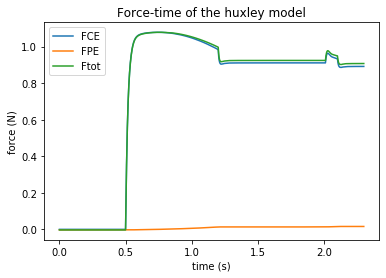

In [ ]:
plt.plot(time_vector[1:framemax_variable],calculated_muscle_forces[:,0][1:framemax_variable],label='FCE')
plt.plot(time_vector[1:framemax_variable],calculated_muscle_forces[:,2][1:framemax_variable]-calculated_muscle_forces[:,0][1:framemax_variable],label='FPE')
plt.plot(time_vector[1:framemax_variable],calculated_muscle_forces[:,2][1:framemax_variable],label='Ftot')
plt.title('Force-time of the huxley model')
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend()
#plt.savefig('Results/'+save_name+'Ft_hux_EXP1.png')

In [ ]:
huxbefore, huxafter = calculated_muscle_forces[:,2][framemin_variable],calculated_muscle_forces[:,2][framemax_variable2]
hill1before, hill1after = calculated_hill_forces_FVhill[framemin_variable],calculated_hill_forces_FVhill[framemax_variable2]
hill2before, hill2after = calculated_hill_forces[framemin_variable],calculated_hill_forces[framemax_variable2]
print('huxley before, after:')
print(huxbefore)
print(huxafter)
print('hill1 before, after:')
print(hill1before)
print(hill1after)
print('hill2 before, after:')
print(hill2before)
print(hill2after)

NameError: name 'framemin_variable' is not defined

In [ ]:
startt = int(1.0*2500)
plt.plot(time_vector[startt:],K_CE[startt:])

In [ ]:
'''
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
'''

In [ ]:
'''
popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
plt.plot(xdata, func(xdata, *popt), 'g--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
'''

In [ ]:
def fitfunc(x, a, b, c,d):
    return  a*x**3 + b *x** 2 + c*x + d
#framemin_variable=4900#14800
#framemax_variable2=5500#15800
framemin_variable=4900#14800
framemax_variable2=6500#15800
cropframemin_variable=5026#14800
cropframemax_variable2=5376#15800
plt.figure(figsize=[8,5.7])
xdata = time_vector[cropframemin_variable:cropframemax_variable2]
ydata_hux = calculated_muscle_forces[:,2][cropframemin_variable:cropframemax_variable2]
ydata_hill1noFV = calculated_hill_forces_FV0[cropframemin_variable:cropframemax_variable2]
ydata_hill1yesFV = calculated_hill_forces_FVhill[cropframemin_variable:cropframemax_variable2]
ydata_hill2 = calculated_hill_forces[cropframemin_variable:cropframemax_variable2]
popt_hux, pcov_hux = scipy.optimize.curve_fit(fitfunc, xdata, ydata_hux)
popt_hill1noFV, pcov_hill1noFV = scipy.optimize.curve_fit(fitfunc, xdata, ydata_hill1noFV)
popt_hill1yesFV, pcov_hill1yesFV = scipy.optimize.curve_fit(fitfunc, xdata, ydata_hill1yesFV)
popt_hill2, pcov_hill2 = scipy.optimize.curve_fit(fitfunc, xdata, ydata_hill2)

plt.plot(time_vector[framemin_variable:framemax_variable2],calculated_muscle_forces[:,2][framemin_variable:framemax_variable2],'r',label='huxley',alpha=0.4,linewidth=4)
plt.plot(time_vector[framemin_variable:framemax_variable2],calculated_hill_forces_FV0[framemin_variable:framemax_variable2],'g',label='hill1 (TU) no FV',alpha=0.4,linewidth=4)
plt.plot(time_vector[framemin_variable:framemax_variable2],calculated_hill_forces_FVhill[framemin_variable:framemax_variable2],'b',label='hill1 (TU) simple FV',alpha=0.4,linewidth=4)
plt.plot(time_vector[framemin_variable:framemax_variable2],calculated_hill_forces[framemin_variable:framemax_variable2],'purple',label='hill2 (stroeve)',alpha=0.4,linewidth=4)

#plt.plot(xdata,ydata_hux,'r',label='huxley',alpha=0.6)
#plt.plot(xdata,ydata_hill1noFV,'g',label='hill1_no_FV',alpha=0.6)
#plt.plot(xdata,ydata_hill1yesFV,'b',label='hill1_yes_FV',alpha=0.6)
#plt.plot(xdata,ydata_hill2,'purple',label='hill2',alpha=0.6)

plt.plot(xdata,fitfunc(xdata, *popt_hux),'r--',label='fitted huxley')
plt.plot(xdata,fitfunc(xdata, *popt_hill1noFV),'g--',label='fitted hill1 (TU) no FV')
plt.plot(xdata,fitfunc(xdata, *popt_hill1yesFV),'b--',label='fitted hill1 (TU) simple FV')
plt.plot(xdata,fitfunc(xdata, *popt_hill2),'purple',linestyle='--',label='fitted hill2 (stroeve)')






plt.title('Zoomed force-time')
plt.xlabel('time (s)')
plt.ylabel('force (N)')
#plt.savefig('Results/'+save_name+'Ftzoomed_all_fitted_EXP1.png')
plt.legend()

In [ ]:
plt.plot(time_vector[framemin_variable:framemax_variable2],calculated_muscle_forces[:,0][framemin_variable:framemax_variable2])
plt.title('Zoomed force-time of the huxley model')
plt.xlabel('time (s)')
plt.ylabel('force (N)')

In [ ]:
plt.plot(time_vector[1:],v_mtc[1:])

In [ ]:
plt.plot(time_vector[1:],K_CE[1:])


In [ ]:
plt.plot(time_vector[1:],calculated_muscle_forces[:,0][1:])

In [ ]:
from save_functions import *
#save_hill(calculated_hill_forces,v_mtc,STIM,lCE,vCE,time_vector,save_name)

In [ ]:
#plt.plot(time_vector[1:],l_mtc[1:])

plt.plot(time_vector[1:],states_hux[1:,-2],label='huxley')
plt.plot(time_vector[1:],states_FVhill[1:,0],label='hill1 (TU) simple FV')
plt.plot(time_vector[1:],states_FV0[1:,0],label='hill1 (TU) no FV')

plt.plot(time_vector,l_mtc-0.2*1.22*l_mtc0,label='hill (stroeve)')
plt.title('CE length of the models')
plt.ylabel('l (m)')
plt.xlabel('t (s)')
plt.legend()

#plt.savefig('Results/LCEt_all_EXP1.png')

In [ ]:
for i in range(4):
    plt.plot(time_vector[1:],force_vector_FVhill[1:,i])
plt.legend(['Ftot','Fce','Fse','Fpe'])

In [ ]:
for i in range(5):
    plt.plot(time_vector[1:],force_vector_FVhill[1:,4+i])
plt.legend(['FL','vmax','FV','vce','frel'] )

In [ ]:
plt.plot(time_vector[1:],force_vector_FVhill[1:,8])
plt.legend(['frel'] )

In [ ]:
plt.plot(time_vector[1:],force_vector_FVhill[1:,6])

In [ ]:
t_vals

In [ ]:
time_vector

In [ ]:
force_vector[1,:]

In [ ]:
calculated_muscle_forces[:,0]

In [ ]:
(1/(np.exp(3-1)))*np.exp(3*0.3/0.1-1)

In [ ]:

np.exp(5*1/0.6-1)

In [ ]:
calculated_muscle_forces[0,2]

In [ ]:
testt = [0,1,2]
testt[-1]



In [ ]:
ppp,qqq = 1,2
ppp,qqq *= 2,2
ppp

In [ ]:
mus_vals_hux = muscle_vals_func()
se0 = SEforce2length(1,mus_vals_hux[0])
print(se0)


In [ ]:
mus_vals_hux[0][0]

In [ ]:
mus_vals_hux = muscle_vals_func()
tot_bridge_nr=10000
fs=2500
t0 = 0.0      #time start point (s)
tf = 7.0       #time end point   (s)
step_nr = int(fs*(tf-t0))#total steps
states_hux = np.zeros((step_nr+1,tot_bridge_nr*2+2))
l_mtc0 = 0.12
muscle_number = 2
model_type = 'huxley'
hill_type='thijs'
Fmax_muscles_actual=1
experiment_name = 'full_curve_shortmuscle'#'zoomed'

specific_save_name = 'stiff_start_mostpos'

mus_vals_changed,states_hux = constant_altering_function(mus_vals_hux[0],l_mtc0,states_hux,muscle_number,tot_bridge_nr,model_type,hill_type,Fmax_muscles_actual,experiment_name,specific_save_name)
print(states_hux[0,-2])